# Import libraries

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import LabelEncoder, label_binarize
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import torch.optim as optim
import torchvision.models as models
import time
import copy
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, f1_score, roc_auc_score
import seaborn as sns
from itertools import cycle
from collections import Counter

# Set Seeds for Reproducibility

In [2]:
import random

# Set seeds for reproducibility
SEED = 42

# Python random
random.seed(SEED)

# Numpy
np.random.seed(SEED)

# PyTorch
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)  # if using multi-GPU

# PyTorch backend
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

print(f"Seeds set to {SEED} for reproducibility")

Seeds set to 42 for reproducibility


# Data Transformation

In [3]:
# Data transformations - Minimal transformations without data augmentation
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),  
    transforms.ToTensor(),
    transforms.ConvertImageDtype(torch.float),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # RGB normalization
])

val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.ConvertImageDtype(torch.float),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # RGB normalization
])

# Dataset

In [4]:
BATCH_SIZE = 16
NUM_WORKERS = 4

class BladderTissueDataset(Dataset):
    def __init__(self, dataframe, transform=None, label_encoder=None, imaging_type_encoder=None, fit_label_encoder=False):
        """
        Args:
            dataframe (DataFrame): DataFrame with HLY (image paths), tissue type (labels), and imaging type columns.
            transform (callable, optional): Optional transform to be applied on a sample.
            label_encoder (LabelEncoder, optional): Pre-fitted label encoder. If None, creates new one.
            imaging_type_encoder (LabelEncoder, optional): Pre-fitted imaging type encoder.
            fit_label_encoder (bool): Whether to fit the label encoder on this dataset's labels.
        """
        self.data = dataframe.reset_index(drop=True)
        self.transform = transform
        
        if label_encoder is None:
            self.label_encoder = LabelEncoder()
            if fit_label_encoder:
                self.labels = self.label_encoder.fit_transform(self.data['tissue type'])
            else:
                raise ValueError("Must provide label_encoder or set fit_label_encoder=True")
        else:
            self.label_encoder = label_encoder
            self.labels = self.label_encoder.transform(self.data['tissue type'])
        
        # Handle imaging type encoding
        if imaging_type_encoder is None:
            self.imaging_type_encoder = LabelEncoder()
            if fit_label_encoder:
                self.imaging_types = self.imaging_type_encoder.fit_transform(self.data['imaging type'])
            else:
                raise ValueError("Must provide imaging_type_encoder or set fit_label_encoder=True")
        else:
            self.imaging_type_encoder = imaging_type_encoder
            self.imaging_types = self.imaging_type_encoder.transform(self.data['imaging type'])
        
        self.image_paths = self.data['HLY'].tolist()
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        # Load image
        img_path = self.image_paths[idx]
        try:
            image = Image.open(img_path).convert('RGB')
        except Exception as e:
            print(f"Error loading image: {img_path}")
            image = Image.new('RGB', (224, 224), color='black')
        
        label = self.labels[idx]
        imaging_type = self.imaging_types[idx]
        
        if self.transform:
            image = self.transform(image)
        
        return image, torch.tensor(label, dtype=torch.long), torch.tensor(imaging_type, dtype=torch.long)
    
    def get_label_encoder(self):
        """Return the label encoder for use with other datasets"""
        return self.label_encoder
    
    def get_imaging_type_encoder(self):
        """Return the imaging type encoder for use with other datasets"""
        return self.imaging_type_encoder
    
    def get_class_names(self):
        """Return the original class names"""
        return self.label_encoder.classes_

In [5]:
# Create datasets from DataFrames
def create_datasets_from_dataframes(train_df, val_df, test_df):
    """
    Create train, validation, and test datasets with proper label encoding
    """
    # Create training dataset and fit label encoder
    train_dataset = BladderTissueDataset(
        dataframe=train_df, 
        transform=train_transform,
        fit_label_encoder=True  
    )
    
    # Get the fitted label encoder and imaging type encoder
    le = train_dataset.get_label_encoder()
    imaging_type_encoder = train_dataset.get_imaging_type_encoder()
    
    # Create validation dataset using the same label encoder
    val_dataset = BladderTissueDataset(
        dataframe=val_df,
        transform=val_test_transform,
        label_encoder=le,
        imaging_type_encoder=imaging_type_encoder
    )
    
    # Create test dataset using the same label encoder
    test_dataset = BladderTissueDataset(
        dataframe=test_df,
        transform=val_test_transform,
        label_encoder=le,
        imaging_type_encoder=imaging_type_encoder
    )
    
    return train_dataset, val_dataset, test_dataset, le, imaging_type_encoder

# Dataloader

In [6]:
# Create dataloaders
def create_dataloaders(train_dataset, val_dataset, test_dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS):
    """
    Create dataloaders for training, validation, and testing
    """
    # Worker seed for reproducibility
    def seed_worker(worker_id):
        worker_seed = torch.initial_seed() % 2**32
        np.random.seed(worker_seed)
        random.seed(worker_seed)
    
    g = torch.Generator()
    g.manual_seed(42)
    
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True,
        drop_last=True,
        worker_init_fn=seed_worker,
        generator=g
    )
    
    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True,
        worker_init_fn=seed_worker,    
        generator=g    
    )

    test_loader = DataLoader(
        test_dataset,
        pin_memory=True,
        batch_size=batch_size,
        num_workers=num_workers,
        shuffle=False,
        worker_init_fn=seed_worker,
        generator=g
    )
    return train_loader, val_loader, test_loader

In [7]:
train_df = pd.read_csv("/kaggle/input/ebt-dataset/train.csv")
test_df = pd.read_csv("/kaggle/input/ebt-dataset/test.csv")
valid_df = pd.read_csv("/kaggle/input/ebt-dataset/valid.csv")

In [8]:
train_dataset, val_dataset, test_dataset, label_encoder, imaging_type_encoder = create_datasets_from_dataframes(
    train_df, valid_df, test_df
)

train_loader, val_loader, test_loader = create_dataloaders(
    train_dataset, val_dataset, test_dataset, 
    batch_size=32, 
    num_workers=4
)

# Utility Functions

In [9]:
def compute_class_weights(train_loader, num_classes):
    """Compute class weights for handling imbalanced datasets"""
    class_counts = Counter()

    for _, labels, _ in train_loader:
        class_counts.update(labels.numpy())

    total_samples = sum(class_counts.values())

    weights = []
    for i in range(num_classes):
        weights.append(total_samples / (num_classes * class_counts[i]))

    return torch.tensor(weights, dtype=torch.float)

# Model Training Framework

In [10]:
class ModelTrainer:
    def __init__(self, model, train_loader, val_loader, test_loader, device='cuda'):
        self.model = model.to(device)
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.test_loader = test_loader
        self.device = device
        
        # Training history
        self.train_losses = []
        self.val_losses = []
        self.train_accuracies = []
        self.val_accuracies = []
        
    def train_model(self, num_epochs=25, lr=0.001, weight_decay=1e-4, save_best=True, model_name="model"):
        """Train the model with early stopping and best model saving based on macro-F1"""
        
        # Loss function and optimizer
        class_weights = compute_class_weights(self.train_loader, num_classes=len(self.train_loader.dataset.get_label_encoder().classes_))
        class_weights = class_weights.to(self.device)
        criterion = nn.CrossEntropyLoss(weight=class_weights)
        optimizer = optim.Adam(self.model.parameters(), lr=lr, weight_decay=weight_decay)
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
        
        # Best model tracking
        best_val_f1 = 0.0
        best_model_wts = copy.deepcopy(self.model.state_dict())
        patience = 5
        patience_counter = 0
        
        print(f"Starting training for {num_epochs} epochs...")
        print("-" * 60)
        
        start_time = time.time()
        
        for epoch in range(num_epochs):
            print(f'Epoch {epoch+1}/{num_epochs}')
            print('-' * 10)
            
            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    self.model.train()
                    dataloader = self.train_loader
                else:
                    self.model.eval()
                    dataloader = self.val_loader
                
                running_loss = 0.0
                running_corrects = 0
                total_samples = 0
                all_preds = []
                all_labels = []
                
                # Progress bar
                pbar = tqdm(dataloader, desc=f'{phase.capitalize()} ')
                
                for inputs, labels, imaging_types in pbar:
                    inputs = inputs.to(self.device)
                    labels = labels.to(self.device)
                    imaging_types = imaging_types.to(self.device)
                    
                    # Zero gradients
                    optimizer.zero_grad()
                    
                    # Forward pass
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = self.model(inputs, imaging_types)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)
                        
                        # Backward pass (only in training)
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()
                    
                    # Statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                    total_samples += inputs.size(0)
                    
                    # Store predictions and labels for F1 calculation
                    all_preds.extend(preds.cpu().numpy())
                    all_labels.extend(labels.cpu().numpy())
                    
                    # Update progress bar
                    current_acc = running_corrects.double() / total_samples
                    pbar.set_postfix({
                        'Loss': f'{running_loss/total_samples:.4f}',
                        'Acc': f'{current_acc:.4f}'
                    })
                
                # Calculate epoch metrics
                epoch_loss = running_loss / total_samples
                epoch_acc = running_corrects.double() / total_samples
                epoch_f1 = f1_score(all_labels, all_preds, average='macro')
                
                print(f'{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} Macro-F1: {epoch_f1:.4f}')
                
                # Store metrics
                if phase == 'train':
                    self.train_losses.append(epoch_loss)
                    self.train_accuracies.append(epoch_acc.cpu())
                else:
                    self.val_losses.append(epoch_loss)
                    self.val_accuracies.append(epoch_acc.cpu())
                
                # Save best model based on validation macro-F1
                if phase == 'val' and epoch_f1 > best_val_f1:
                    best_val_f1 = epoch_f1
                    best_model_wts = copy.deepcopy(self.model.state_dict())
                    patience_counter = 0
                    if save_best:
                        torch.save(self.model.state_dict(), f'best_{model_name}.pth')
                        print(f'✓ New best model saved with validation macro-F1: {best_val_f1:.4f}')
                elif phase == 'val':
                    patience_counter += 1
            
            # Learning rate scheduler step (after both train and val phases)
            scheduler.step()
            
            # Early stopping
            if patience_counter >= patience:
                print(f'Early stopping triggered after {epoch+1} epochs')
                break
                
            print()
        
        # Training complete
        time_elapsed = time.time() - start_time
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best validation macro-F1: {best_val_f1:.4f}')
        
        # Load best model weights
        self.model.load_state_dict(best_model_wts)
        return self.model
    
    def evaluate_model(self, test_loader=None, class_names=['HGC', 'LGC', 'NST', 'NTL']):
        """Evaluate model on test set and return all metrics"""
        if test_loader is None:
            test_loader = self.test_loader
            
        self.model.eval()
        all_preds = []
        all_labels = []
        all_probs = []
        test_loss = 0.0
        correct = 0
        total = 0
        
        criterion = nn.CrossEntropyLoss()
        
        print("Evaluating on test set...")
        with torch.no_grad():
            for inputs, labels, imaging_types in tqdm(test_loader):
                inputs = inputs.to(self.device)
                labels = labels.to(self.device)
                imaging_types = imaging_types.to(self.device)
                
                outputs = self.model(inputs, imaging_types)
                probs = torch.softmax(outputs, dim=1)
                loss = criterion(outputs, labels)
                
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                test_loss += loss.item() * inputs.size(0)
                
                # Store for detailed metrics
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
                all_probs.extend(probs.cpu().numpy())
        
        # Calculate metrics
        test_acc = 100 * correct / total
        avg_test_loss = test_loss / total
        
        print(f'Test Accuracy: {test_acc:.2f}%')
        print(f'Test Loss: {avg_test_loss:.4f}')
        
        # Detailed classification report
        print("\nClassification Report:")
        report = classification_report(all_labels, all_preds, target_names=class_names, output_dict=True)
        print(classification_report(all_labels, all_preds, target_names=class_names))
        
        # Confusion Matrix
        cm = confusion_matrix(all_labels, all_preds)
        print(f"\nConfusion Matrix:")
        print(cm)
        
        # Compute ROC-AUC scores
        labels_bin = label_binarize(all_labels, classes=list(range(len(class_names))))
        probs_array = np.array(all_probs)
        
        # Per-class ROC-AUC
        per_class_auc = {}
        for i, class_name in enumerate(class_names):
            try:
                per_class_auc[class_name] = roc_auc_score(labels_bin[:, i], probs_array[:, i])
            except:
                per_class_auc[class_name] = 0.0
        
        # Macro ROC-AUC (average of per-class AUCs)
        macro_auc = np.mean(list(per_class_auc.values()))
        
        # Micro ROC-AUC (using all predictions)
        try:
            micro_auc = roc_auc_score(labels_bin.ravel(), probs_array.ravel())
        except:
            micro_auc = 0.0
        
        print(f"\nROC-AUC Scores:")
        print(f"Macro-average AUC: {macro_auc:.4f}")
        print(f"Micro-average AUC: {micro_auc:.4f}")
        for class_name, auc_score in per_class_auc.items():
            print(f"{class_name} AUC: {auc_score:.4f}")
        
        return {
            'accuracy': test_acc,
            'loss': avg_test_loss,
            'predictions': all_preds,
            'labels': all_labels,
            'probabilities': all_probs,
            'confusion_matrix': cm,
            'classification_report': report,
            'per_class_auc': per_class_auc,
            'macro_auc': macro_auc,
            'micro_auc': micro_auc
        }
    
    def plot_training_history(self, save_path=None):
        """Plot training and validation metrics"""
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
        
        # Plot losses
        ax1.plot(self.train_losses, label='Train Loss', marker='o')
        ax1.plot(self.val_losses, label='Validation Loss', marker='s')
        ax1.set_title('Model Loss')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')
        ax1.legend()
        ax1.grid(True)
        
        # Plot accuracies
        ax2.plot(self.train_accuracies, label='Train Accuracy', marker='o')
        ax2.plot(self.val_accuracies, label='Validation Accuracy', marker='s')
        ax2.set_title('Model Accuracy')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Accuracy')
        ax2.legend()
        ax2.grid(True)
        
        plt.tight_layout()
        
        if save_path:
            plt.savefig(save_path)
        ax2.set_xlabel('Epoch')

# Model Definitions

In [11]:
class ResNetWithImagingType(nn.Module):
    def __init__(self, base_model, num_features, num_classes=4, num_imaging_types=2, embedding_dim=16):
        super(ResNetWithImagingType, self).__init__()
        self.base_model = base_model
        
        # Remove the final fc layer
        self.base_model.fc = nn.Identity()
        
        # Imaging type embedding
        self.imaging_type_embedding = nn.Embedding(num_imaging_types, embedding_dim)
        
        # New classifier that takes both image features and imaging type
        self.classifier = nn.Linear(num_features + embedding_dim, num_classes)
        
    def forward(self, x, imaging_type):
        # Get image features
        image_features = self.base_model(x)
        
        # Get imaging type embedding
        imaging_embedding = self.imaging_type_embedding(imaging_type)
        
        # Concatenate features
        combined_features = torch.cat([image_features, imaging_embedding], dim=1)
        
        # Final classification
        output = self.classifier(combined_features)
        return output

def create_resnet_model(model_type='resnet50', num_classes=4, num_imaging_types=2, pretrained=True):
    """
    Create ResNet model with imaging type input for bladder tissue classification
    
    Args:
        model_type (str): ResNet architecture - 'resnet50' or 'resnet101'
        num_classes (int): Number of output classes
        num_imaging_types (int): Number of imaging types
        pretrained (bool): Whether to use pretrained weights
    
    Returns:
        model: ResNet model with imaging type support
    """
    if model_type == 'resnet50':
        base_model = models.resnet50(pretrained=pretrained)
    elif model_type == 'resnet101':
        base_model = models.resnet101(pretrained=pretrained)
    else:
        raise ValueError(f"Unsupported model type: {model_type}")
    
    # Get num_features before modifying the model
    num_features = base_model.fc.in_features
    
    # Wrap with imaging type support
    model = ResNetWithImagingType(base_model, num_features=num_features, num_classes=num_classes, num_imaging_types=num_imaging_types)
    
    return model

# Configure GPU

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


# Visualization Functions

In [13]:
def plot_confusion_matrix(cm, class_names, model_name, save_path=None):
    """Plot confusion matrix with nice formatting"""
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names,
                cbar_kws={'label': 'Count'})
    plt.title(f'Confusion Matrix - {model_name}', fontsize=16, pad=20)
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

def plot_roc_curves(labels, probs, class_names, model_name, save_path=None):
    """Plot ROC curves for multi-class classification"""
    # Binarize the labels
    n_classes = len(class_names)
    labels_bin = label_binarize(labels, classes=list(range(n_classes)))
    probs_array = np.array(probs)
    
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(labels_bin[:, i], probs_array[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(labels_bin.ravel(), probs_array.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    
    # Plot ROC curves
    plt.figure(figsize=(12, 8))
    colors = cycle(['blue', 'red', 'green', 'orange', 'purple'])
    
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label=f'{class_names[i]} (AUC = {roc_auc[i]:.3f})')
    
    plt.plot(fpr["micro"], tpr["micro"], color='deeppink', linestyle=':', linewidth=3,
             label=f'Micro-average (AUC = {roc_auc["micro"]:.3f})')
    
    plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title(f'ROC Curves - {model_name}', fontsize=16, pad=20)
    plt.legend(loc="lower right", fontsize=10)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    
    return roc_auc

# Train and Evaluate Models

In [14]:
# Get class names from label encoder
class_names = list(label_encoder.classes_)
print(f"Classes: {class_names}")

# Store results for all models
all_results = []

Classes: ['HGC', 'LGC', 'NST', 'NTL']


## Train ResNet-50

Training ResNet-50 with Imaging Type


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 197MB/s]


Starting training for 25 epochs...
------------------------------------------------------------
Epoch 1/25
----------


Train : 100%|██████████| 38/38 [00:08<00:00,  4.48it/s, Loss=0.9865, Acc=0.6488]


Train Loss: 0.9865 Acc: 0.6488 Macro-F1: 0.5933


Val : 100%|██████████| 10/10 [00:01<00:00,  5.36it/s, Loss=1.4984, Acc=0.7237]


Val Loss: 1.4984 Acc: 0.7237 Macro-F1: 0.5644
✓ New best model saved with validation macro-F1: 0.5644

Epoch 2/25
----------


Train : 100%|██████████| 38/38 [00:07<00:00,  5.13it/s, Loss=0.6470, Acc=0.7747]


Train Loss: 0.6470 Acc: 0.7747 Macro-F1: 0.7233


Val : 100%|██████████| 10/10 [00:01<00:00,  9.33it/s, Loss=0.9015, Acc=0.6316]


Val Loss: 0.9015 Acc: 0.6316 Macro-F1: 0.6192
✓ New best model saved with validation macro-F1: 0.6192

Epoch 3/25
----------


Train : 100%|██████████| 38/38 [00:07<00:00,  5.13it/s, Loss=0.4337, Acc=0.8709]


Train Loss: 0.4337 Acc: 0.8709 Macro-F1: 0.8275


Val : 100%|██████████| 10/10 [00:01<00:00,  9.48it/s, Loss=4.9708, Acc=0.3224]


Val Loss: 4.9708 Acc: 0.3224 Macro-F1: 0.2234

Epoch 4/25
----------


Train : 100%|██████████| 38/38 [00:07<00:00,  5.15it/s, Loss=0.3637, Acc=0.8840]


Train Loss: 0.3637 Acc: 0.8840 Macro-F1: 0.8500


Val : 100%|██████████| 10/10 [00:01<00:00,  9.33it/s, Loss=0.2011, Acc=0.9079]


Val Loss: 0.2011 Acc: 0.9079 Macro-F1: 0.8907
✓ New best model saved with validation macro-F1: 0.8907

Epoch 5/25
----------


Train : 100%|██████████| 38/38 [00:07<00:00,  5.15it/s, Loss=0.2295, Acc=0.9252]


Train Loss: 0.2295 Acc: 0.9252 Macro-F1: 0.9011


Val : 100%|██████████| 10/10 [00:01<00:00,  9.01it/s, Loss=0.4115, Acc=0.8586]


Val Loss: 0.4115 Acc: 0.8586 Macro-F1: 0.8369

Epoch 6/25
----------


Train : 100%|██████████| 38/38 [00:07<00:00,  5.17it/s, Loss=0.2292, Acc=0.9309]


Train Loss: 0.2292 Acc: 0.9309 Macro-F1: 0.9130


Val : 100%|██████████| 10/10 [00:01<00:00,  9.53it/s, Loss=0.2948, Acc=0.9178]


Val Loss: 0.2948 Acc: 0.9178 Macro-F1: 0.9092
✓ New best model saved with validation macro-F1: 0.9092

Epoch 7/25
----------


Train : 100%|██████████| 38/38 [00:07<00:00,  5.15it/s, Loss=0.3185, Acc=0.8931]


Train Loss: 0.3185 Acc: 0.8931 Macro-F1: 0.8642


Val : 100%|██████████| 10/10 [00:01<00:00,  9.48it/s, Loss=6.1418, Acc=0.3553]


Val Loss: 6.1418 Acc: 0.3553 Macro-F1: 0.3112

Epoch 8/25
----------


Train : 100%|██████████| 38/38 [00:07<00:00,  5.15it/s, Loss=0.1647, Acc=0.9326]


Train Loss: 0.1647 Acc: 0.9326 Macro-F1: 0.9277


Val : 100%|██████████| 10/10 [00:01<00:00,  9.43it/s, Loss=0.1013, Acc=0.9704]


Val Loss: 0.1013 Acc: 0.9704 Macro-F1: 0.9601
✓ New best model saved with validation macro-F1: 0.9601

Epoch 9/25
----------


Train : 100%|██████████| 38/38 [00:07<00:00,  5.16it/s, Loss=0.0824, Acc=0.9786]


Train Loss: 0.0824 Acc: 0.9786 Macro-F1: 0.9761


Val : 100%|██████████| 10/10 [00:01<00:00,  9.50it/s, Loss=0.0824, Acc=0.9737]


Val Loss: 0.0824 Acc: 0.9737 Macro-F1: 0.9669
✓ New best model saved with validation macro-F1: 0.9669

Epoch 10/25
----------


Train : 100%|██████████| 38/38 [00:07<00:00,  5.13it/s, Loss=0.0522, Acc=0.9877]


Train Loss: 0.0522 Acc: 0.9877 Macro-F1: 0.9878


Val : 100%|██████████| 10/10 [00:01<00:00,  9.59it/s, Loss=0.0702, Acc=0.9671]


Val Loss: 0.0702 Acc: 0.9671 Macro-F1: 0.9572

Epoch 11/25
----------


Train : 100%|██████████| 38/38 [00:07<00:00,  5.16it/s, Loss=0.0363, Acc=0.9893]


Train Loss: 0.0363 Acc: 0.9893 Macro-F1: 0.9912


Val : 100%|██████████| 10/10 [00:01<00:00,  9.32it/s, Loss=0.0580, Acc=0.9737]


Val Loss: 0.0580 Acc: 0.9737 Macro-F1: 0.9669

Epoch 12/25
----------


Train : 100%|██████████| 38/38 [00:07<00:00,  5.15it/s, Loss=0.0325, Acc=0.9918]


Train Loss: 0.0325 Acc: 0.9918 Macro-F1: 0.9933


Val : 100%|██████████| 10/10 [00:01<00:00,  8.84it/s, Loss=0.0606, Acc=0.9803]


Val Loss: 0.0606 Acc: 0.9803 Macro-F1: 0.9724
✓ New best model saved with validation macro-F1: 0.9724

Epoch 13/25
----------


Train : 100%|██████████| 38/38 [00:07<00:00,  5.13it/s, Loss=0.0247, Acc=0.9934]


Train Loss: 0.0247 Acc: 0.9934 Macro-F1: 0.9947


Val : 100%|██████████| 10/10 [00:01<00:00,  9.37it/s, Loss=0.0591, Acc=0.9737]


Val Loss: 0.0591 Acc: 0.9737 Macro-F1: 0.9627

Epoch 14/25
----------


Train : 100%|██████████| 38/38 [00:07<00:00,  5.13it/s, Loss=0.0226, Acc=0.9967]


Train Loss: 0.0226 Acc: 0.9967 Macro-F1: 0.9951


Val : 100%|██████████| 10/10 [00:01<00:00,  9.74it/s, Loss=0.0458, Acc=0.9803]


Val Loss: 0.0458 Acc: 0.9803 Macro-F1: 0.9721

Epoch 15/25
----------


Train : 100%|██████████| 38/38 [00:07<00:00,  5.14it/s, Loss=0.0178, Acc=0.9984]


Train Loss: 0.0178 Acc: 0.9984 Macro-F1: 0.9986


Val : 100%|██████████| 10/10 [00:01<00:00,  9.27it/s, Loss=0.0459, Acc=0.9836]


Val Loss: 0.0459 Acc: 0.9836 Macro-F1: 0.9751
✓ New best model saved with validation macro-F1: 0.9751

Epoch 16/25
----------


Train : 100%|██████████| 38/38 [00:07<00:00,  5.17it/s, Loss=0.0178, Acc=0.9975]


Train Loss: 0.0178 Acc: 0.9975 Macro-F1: 0.9980


Val : 100%|██████████| 10/10 [00:01<00:00,  9.18it/s, Loss=0.0440, Acc=0.9803]


Val Loss: 0.0440 Acc: 0.9803 Macro-F1: 0.9724

Epoch 17/25
----------


Train : 100%|██████████| 38/38 [00:07<00:00,  5.15it/s, Loss=0.0162, Acc=0.9984]


Train Loss: 0.0162 Acc: 0.9984 Macro-F1: 0.9987


Val : 100%|██████████| 10/10 [00:01<00:00,  9.41it/s, Loss=0.0440, Acc=0.9803]


Val Loss: 0.0440 Acc: 0.9803 Macro-F1: 0.9721

Epoch 18/25
----------


Train : 100%|██████████| 38/38 [00:07<00:00,  5.16it/s, Loss=0.0195, Acc=0.9959]


Train Loss: 0.0195 Acc: 0.9959 Macro-F1: 0.9956


Val : 100%|██████████| 10/10 [00:01<00:00,  9.31it/s, Loss=0.0441, Acc=0.9803]


Val Loss: 0.0441 Acc: 0.9803 Macro-F1: 0.9721

Epoch 19/25
----------


Train : 100%|██████████| 38/38 [00:07<00:00,  5.11it/s, Loss=0.0155, Acc=0.9992]


Train Loss: 0.0155 Acc: 0.9992 Macro-F1: 0.9994


Val : 100%|██████████| 10/10 [00:01<00:00,  8.87it/s, Loss=0.0458, Acc=0.9803]


Val Loss: 0.0458 Acc: 0.9803 Macro-F1: 0.9721

Epoch 20/25
----------


Train : 100%|██████████| 38/38 [00:07<00:00,  5.12it/s, Loss=0.0162, Acc=0.9984]


Train Loss: 0.0162 Acc: 0.9984 Macro-F1: 0.9986


Val : 100%|██████████| 10/10 [00:01<00:00,  9.32it/s, Loss=0.0427, Acc=0.9770]


Val Loss: 0.0427 Acc: 0.9770 Macro-F1: 0.9695
Early stopping triggered after 20 epochs
Training complete in 2m 53s
Best validation macro-F1: 0.9751
Evaluating on test set...


100%|██████████| 6/6 [00:01<00:00,  4.38it/s]


Test Accuracy: 31.22%
Test Loss: 2.9671

Classification Report:
              precision    recall  f1-score   support

         HGC       0.48      0.19      0.27        74
         LGC       0.12      0.13      0.13        53
         NST       0.44      0.41      0.42        37
         NTL       0.34      0.92      0.49        25

    accuracy                           0.31       189
   macro avg       0.35      0.41      0.33       189
weighted avg       0.35      0.31      0.29       189


Confusion Matrix:
[[14 50  8  2]
 [13  7 11 22]
 [ 0  1 15 21]
 [ 2  0  0 23]]

ROC-AUC Scores:
Macro-average AUC: 0.6825
Micro-average AUC: 0.6470
HGC AUC: 0.7951
LGC AUC: 0.3937
NST AUC: 0.6520
NTL AUC: 0.8890


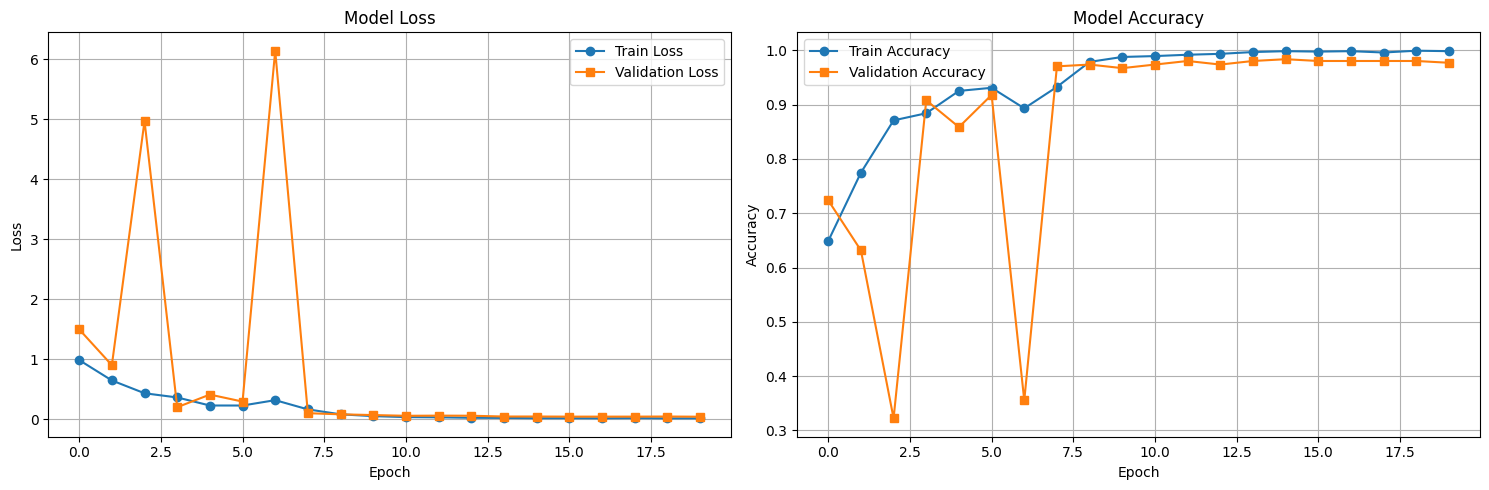

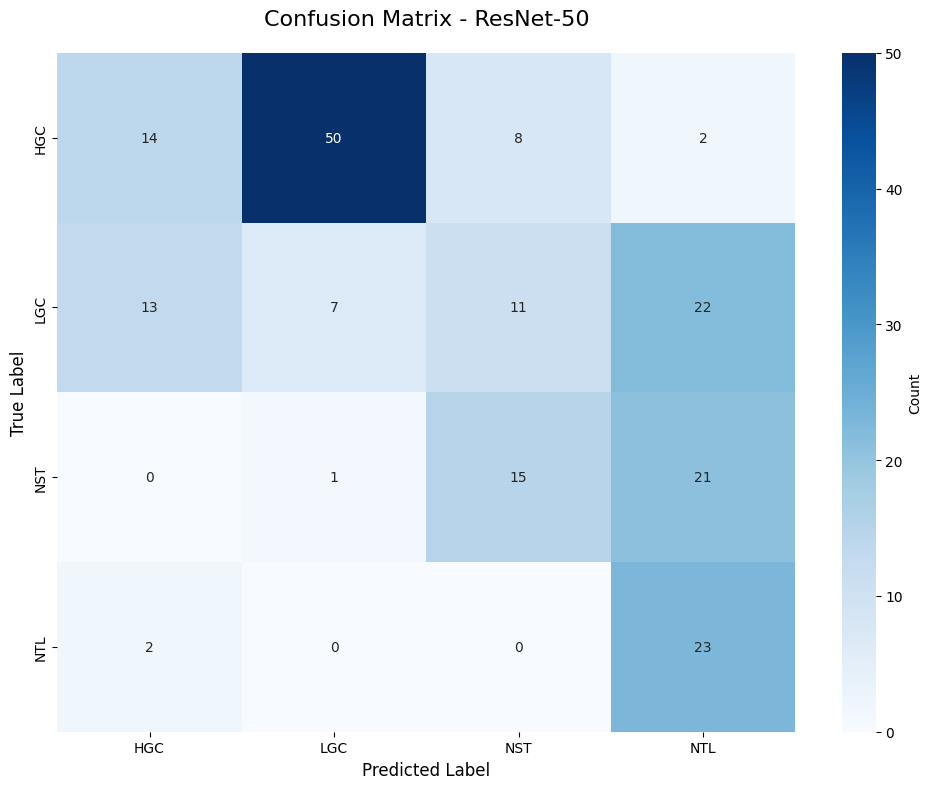

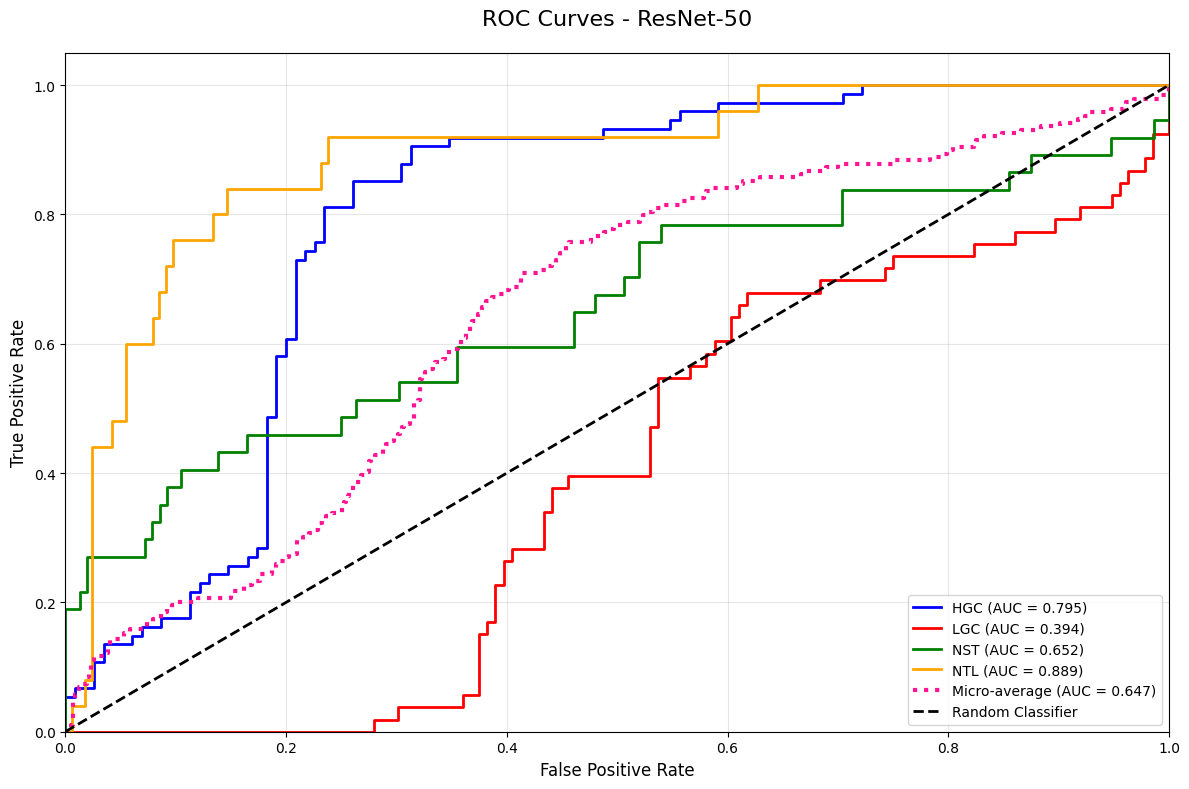


ResNet-50 training and evaluation complete!


In [15]:
print("=" * 80)
print("Training ResNet-50 with Imaging Type")
print("=" * 80)

# Create model
resnet50 = create_resnet_model(model_type='resnet50', num_classes=4, num_imaging_types=2, pretrained=True)

# Create trainer
trainer_50 = ModelTrainer(resnet50, train_loader, val_loader, test_loader, device=device)

# Train model
trained_model_50 = trainer_50.train_model(num_epochs=25, lr=0.001, save_best=True, model_name="resnet50_with_ImagingType")

# Plot training history
trainer_50.plot_training_history(save_path='resnet50_training_history.png')

# Evaluate model
results_50 = trainer_50.evaluate_model(class_names=class_names)

# Plot confusion matrix
plot_confusion_matrix(results_50['confusion_matrix'], class_names, 'ResNet-50',
                      save_path='resnet50_confusion_matrix.png')

# Plot ROC curves
roc_auc_50 = plot_roc_curves(results_50['labels'], results_50['probabilities'], class_names, 'ResNet-50',
                              save_path='resnet50_roc_curves.png')
# Store results
results_50['model_name'] = 'ResNet-50'
results_50['roc_auc'] = roc_auc_50
all_results.append(results_50)

print("\nResNet-50 training and evaluation complete!")

## Train ResNet-101

Training ResNet-101 with Imaging Type


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth


100%|██████████| 171M/171M [00:00<00:00, 232MB/s]


Starting training for 25 epochs...
------------------------------------------------------------
Epoch 1/25
----------


Train : 100%|██████████| 38/38 [00:11<00:00,  3.38it/s, Loss=1.0300, Acc=0.6431]


Train Loss: 1.0300 Acc: 0.6431 Macro-F1: 0.5906


Val : 100%|██████████| 10/10 [00:01<00:00,  7.52it/s, Loss=2.0924, Acc=0.5461]


Val Loss: 2.0924 Acc: 0.5461 Macro-F1: 0.3552
✓ New best model saved with validation macro-F1: 0.3552

Epoch 2/25
----------


Train : 100%|██████████| 38/38 [00:11<00:00,  3.38it/s, Loss=0.6991, Acc=0.7747]


Train Loss: 0.6991 Acc: 0.7747 Macro-F1: 0.7201


Val : 100%|██████████| 10/10 [00:01<00:00,  7.64it/s, Loss=1.0920, Acc=0.5296]


Val Loss: 1.0920 Acc: 0.5296 Macro-F1: 0.5064
✓ New best model saved with validation macro-F1: 0.5064

Epoch 3/25
----------


Train : 100%|██████████| 38/38 [00:11<00:00,  3.37it/s, Loss=0.4989, Acc=0.8388]


Train Loss: 0.4989 Acc: 0.8388 Macro-F1: 0.7977


Val : 100%|██████████| 10/10 [00:01<00:00,  7.64it/s, Loss=0.4735, Acc=0.8553]


Val Loss: 0.4735 Acc: 0.8553 Macro-F1: 0.7725
✓ New best model saved with validation macro-F1: 0.7725

Epoch 4/25
----------


Train : 100%|██████████| 38/38 [00:11<00:00,  3.37it/s, Loss=0.4128, Acc=0.8635]


Train Loss: 0.4128 Acc: 0.8635 Macro-F1: 0.8258


Val : 100%|██████████| 10/10 [00:01<00:00,  7.66it/s, Loss=0.3653, Acc=0.8914]


Val Loss: 0.3653 Acc: 0.8914 Macro-F1: 0.8668
✓ New best model saved with validation macro-F1: 0.8668

Epoch 5/25
----------


Train : 100%|██████████| 38/38 [00:11<00:00,  3.36it/s, Loss=0.3901, Acc=0.8808]


Train Loss: 0.3901 Acc: 0.8808 Macro-F1: 0.8388


Val : 100%|██████████| 10/10 [00:01<00:00,  7.74it/s, Loss=0.6016, Acc=0.7500]


Val Loss: 0.6016 Acc: 0.7500 Macro-F1: 0.6995

Epoch 6/25
----------


Train : 100%|██████████| 38/38 [00:11<00:00,  3.38it/s, Loss=0.3070, Acc=0.9013]


Train Loss: 0.3070 Acc: 0.9013 Macro-F1: 0.8648


Val : 100%|██████████| 10/10 [00:01<00:00,  7.64it/s, Loss=0.4665, Acc=0.8783]


Val Loss: 0.4665 Acc: 0.8783 Macro-F1: 0.8450

Epoch 7/25
----------


Train : 100%|██████████| 38/38 [00:11<00:00,  3.38it/s, Loss=0.2547, Acc=0.9227]


Train Loss: 0.2547 Acc: 0.9227 Macro-F1: 0.8981


Val : 100%|██████████| 10/10 [00:01<00:00,  7.59it/s, Loss=0.8245, Acc=0.7237]


Val Loss: 0.8245 Acc: 0.7237 Macro-F1: 0.6964

Epoch 8/25
----------


Train : 100%|██████████| 38/38 [00:11<00:00,  3.38it/s, Loss=0.1234, Acc=0.9622]


Train Loss: 0.1234 Acc: 0.9622 Macro-F1: 0.9525


Val : 100%|██████████| 10/10 [00:01<00:00,  7.71it/s, Loss=0.0976, Acc=0.9737]


Val Loss: 0.0976 Acc: 0.9737 Macro-F1: 0.9611
✓ New best model saved with validation macro-F1: 0.9611

Epoch 9/25
----------


Train : 100%|██████████| 38/38 [00:11<00:00,  3.38it/s, Loss=0.0622, Acc=0.9852]


Train Loss: 0.0622 Acc: 0.9852 Macro-F1: 0.9815


Val : 100%|██████████| 10/10 [00:01<00:00,  7.68it/s, Loss=0.0810, Acc=0.9803]


Val Loss: 0.0810 Acc: 0.9803 Macro-F1: 0.9651
✓ New best model saved with validation macro-F1: 0.9651

Epoch 10/25
----------


Train : 100%|██████████| 38/38 [00:11<00:00,  3.39it/s, Loss=0.0479, Acc=0.9877]


Train Loss: 0.0479 Acc: 0.9877 Macro-F1: 0.9888


Val : 100%|██████████| 10/10 [00:01<00:00,  7.46it/s, Loss=0.0615, Acc=0.9770]


Val Loss: 0.0615 Acc: 0.9770 Macro-F1: 0.9674
✓ New best model saved with validation macro-F1: 0.9674

Epoch 11/25
----------


Train : 100%|██████████| 38/38 [00:11<00:00,  3.38it/s, Loss=0.0366, Acc=0.9918]


Train Loss: 0.0366 Acc: 0.9918 Macro-F1: 0.9934


Val : 100%|██████████| 10/10 [00:01<00:00,  7.66it/s, Loss=0.0541, Acc=0.9770]


Val Loss: 0.0541 Acc: 0.9770 Macro-F1: 0.9674

Epoch 12/25
----------


Train : 100%|██████████| 38/38 [00:11<00:00,  3.37it/s, Loss=0.0320, Acc=0.9934]


Train Loss: 0.0320 Acc: 0.9934 Macro-F1: 0.9925


Val : 100%|██████████| 10/10 [00:01<00:00,  7.46it/s, Loss=0.0527, Acc=0.9803]


Val Loss: 0.0527 Acc: 0.9803 Macro-F1: 0.9749
✓ New best model saved with validation macro-F1: 0.9749

Epoch 13/25
----------


Train : 100%|██████████| 38/38 [00:11<00:00,  3.38it/s, Loss=0.0388, Acc=0.9901]


Train Loss: 0.0388 Acc: 0.9901 Macro-F1: 0.9876


Val : 100%|██████████| 10/10 [00:01<00:00,  7.60it/s, Loss=0.0525, Acc=0.9803]


Val Loss: 0.0525 Acc: 0.9803 Macro-F1: 0.9750
✓ New best model saved with validation macro-F1: 0.9750

Epoch 14/25
----------


Train : 100%|██████████| 38/38 [00:11<00:00,  3.38it/s, Loss=0.0222, Acc=0.9967]


Train Loss: 0.0222 Acc: 0.9967 Macro-F1: 0.9975


Val : 100%|██████████| 10/10 [00:01<00:00,  7.63it/s, Loss=0.0479, Acc=0.9836]


Val Loss: 0.0479 Acc: 0.9836 Macro-F1: 0.9775
✓ New best model saved with validation macro-F1: 0.9775

Epoch 15/25
----------


Train : 100%|██████████| 38/38 [00:11<00:00,  3.38it/s, Loss=0.0199, Acc=0.9951]


Train Loss: 0.0199 Acc: 0.9951 Macro-F1: 0.9961


Val : 100%|██████████| 10/10 [00:01<00:00,  7.70it/s, Loss=0.0501, Acc=0.9836]


Val Loss: 0.0501 Acc: 0.9836 Macro-F1: 0.9775

Epoch 16/25
----------


Train : 100%|██████████| 38/38 [00:11<00:00,  3.37it/s, Loss=0.0188, Acc=0.9975]


Train Loss: 0.0188 Acc: 0.9975 Macro-F1: 0.9980


Val : 100%|██████████| 10/10 [00:01<00:00,  7.63it/s, Loss=0.0477, Acc=0.9868]


Val Loss: 0.0477 Acc: 0.9868 Macro-F1: 0.9805
✓ New best model saved with validation macro-F1: 0.9805

Epoch 17/25
----------


Train : 100%|██████████| 38/38 [00:11<00:00,  3.38it/s, Loss=0.0188, Acc=0.9975]


Train Loss: 0.0188 Acc: 0.9975 Macro-F1: 0.9969


Val : 100%|██████████| 10/10 [00:01<00:00,  7.73it/s, Loss=0.0481, Acc=0.9836]


Val Loss: 0.0481 Acc: 0.9836 Macro-F1: 0.9775

Epoch 18/25
----------


Train : 100%|██████████| 38/38 [00:11<00:00,  3.38it/s, Loss=0.0176, Acc=0.9967]


Train Loss: 0.0176 Acc: 0.9967 Macro-F1: 0.9961


Val : 100%|██████████| 10/10 [00:01<00:00,  7.65it/s, Loss=0.0488, Acc=0.9836]


Val Loss: 0.0488 Acc: 0.9836 Macro-F1: 0.9775

Epoch 19/25
----------


Train : 100%|██████████| 38/38 [00:11<00:00,  3.36it/s, Loss=0.0182, Acc=0.9967]


Train Loss: 0.0182 Acc: 0.9967 Macro-F1: 0.9972


Val : 100%|██████████| 10/10 [00:01<00:00,  7.41it/s, Loss=0.0489, Acc=0.9803]


Val Loss: 0.0489 Acc: 0.9803 Macro-F1: 0.9750

Epoch 20/25
----------


Train : 100%|██████████| 38/38 [00:11<00:00,  3.37it/s, Loss=0.0141, Acc=0.9975]


Train Loss: 0.0141 Acc: 0.9975 Macro-F1: 0.9980


Val : 100%|██████████| 10/10 [00:01<00:00,  7.52it/s, Loss=0.0474, Acc=0.9868]


Val Loss: 0.0474 Acc: 0.9868 Macro-F1: 0.9805

Epoch 21/25
----------


Train : 100%|██████████| 38/38 [00:11<00:00,  3.38it/s, Loss=0.0216, Acc=0.9959]


Train Loss: 0.0216 Acc: 0.9959 Macro-F1: 0.9967


Val : 100%|██████████| 10/10 [00:01<00:00,  7.61it/s, Loss=0.0471, Acc=0.9868]


Val Loss: 0.0471 Acc: 0.9868 Macro-F1: 0.9805
Early stopping triggered after 21 epochs
Training complete in 4m 28s
Best validation macro-F1: 0.9805
Evaluating on test set...


100%|██████████| 6/6 [00:00<00:00,  6.18it/s]


Test Accuracy: 44.97%
Test Loss: 2.2696

Classification Report:
              precision    recall  f1-score   support

         HGC       0.67      0.54      0.60        74
         LGC       0.23      0.19      0.21        53
         NST       0.45      0.41      0.43        37
         NTL       0.38      0.80      0.51        25

    accuracy                           0.45       189
   macro avg       0.43      0.48      0.44       189
weighted avg       0.47      0.45      0.44       189


Confusion Matrix:
[[40 25  8  1]
 [20 10  5 18]
 [ 0  8 15 14]
 [ 0  0  5 20]]

ROC-AUC Scores:
Macro-average AUC: 0.7142
Micro-average AUC: 0.7115
HGC AUC: 0.7707
LGC AUC: 0.4635
NST AUC: 0.7630
NTL AUC: 0.8598


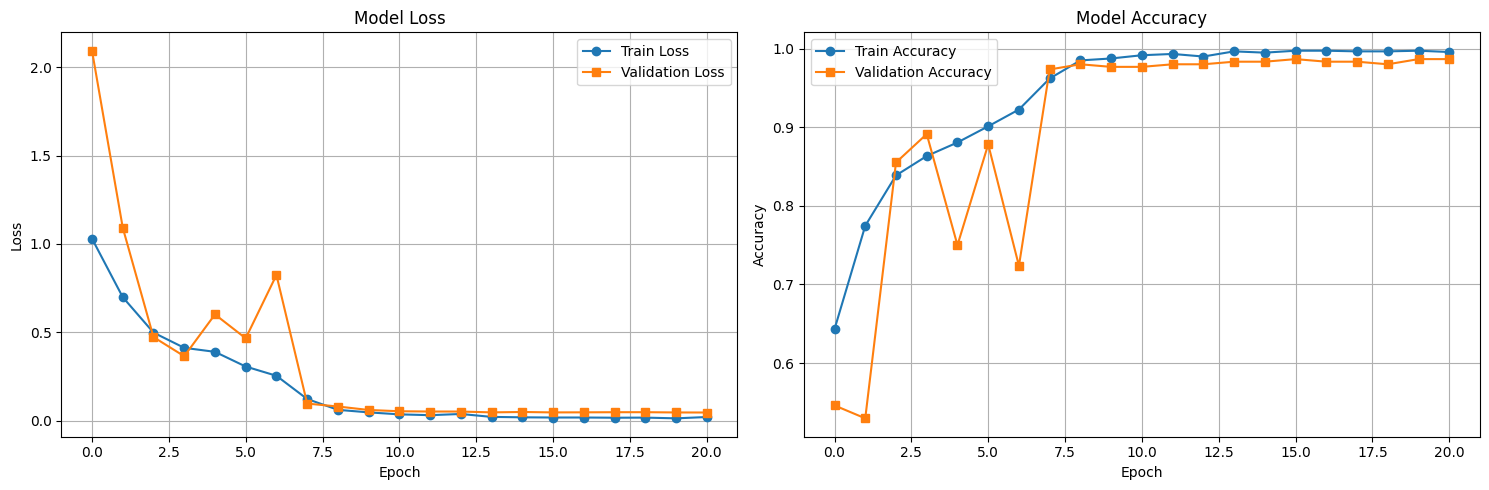

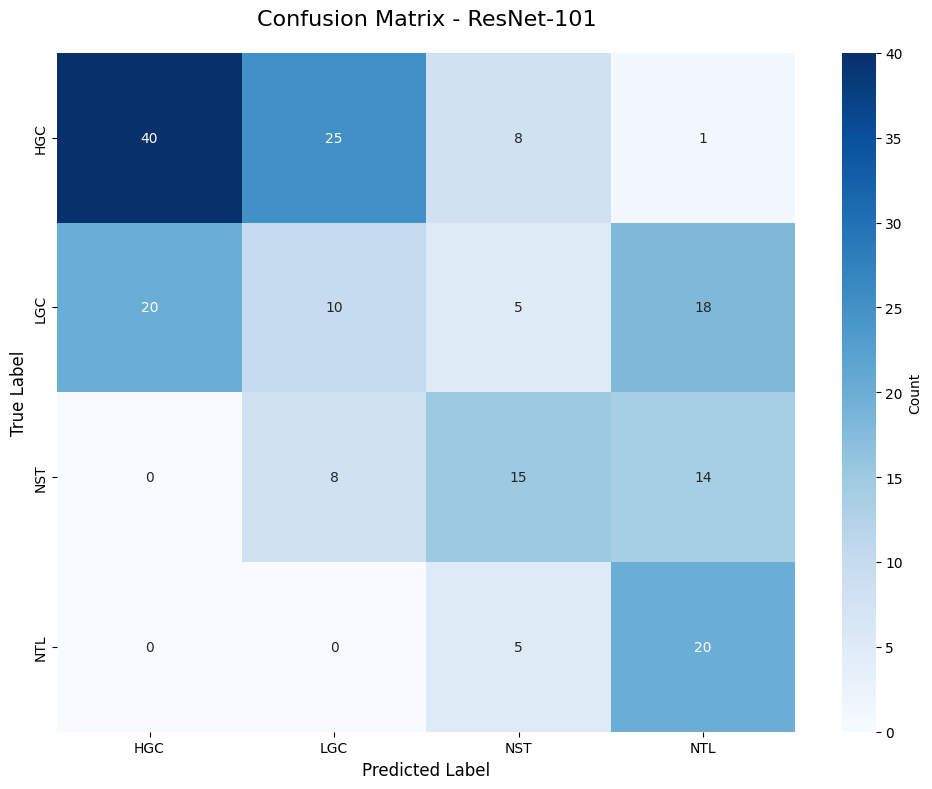

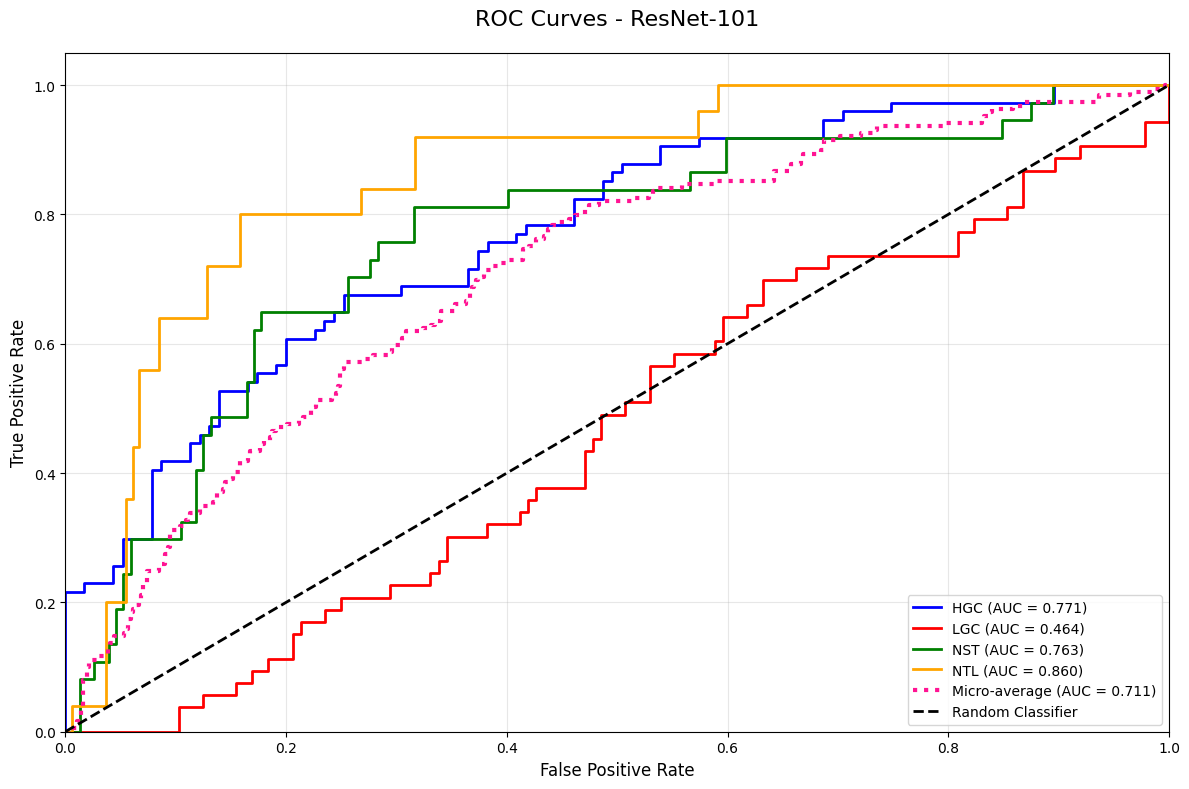


ResNet-101 training and evaluation complete!


In [16]:
print("=" * 80)
print("Training ResNet-101 with Imaging Type")
print("=" * 80)

# Create model
resnet101 = create_resnet_model(model_type='resnet101', num_classes=4, num_imaging_types=2, pretrained=True)

# Create trainer
trainer_101 = ModelTrainer(resnet101, train_loader, val_loader, test_loader, device=device)

# Train model
trained_model_101 = trainer_101.train_model(num_epochs=25, lr=0.001, save_best=True, model_name="resnet101_with_ImagingType")

# Plot training history
trainer_101.plot_training_history(save_path='resnet101_training_history.png')

# Evaluate model
results_101 = trainer_101.evaluate_model(class_names=class_names)

# Plot confusion matrix
plot_confusion_matrix(results_101['confusion_matrix'], class_names, 'ResNet-101',
                      save_path='resnet101_confusion_matrix.png')

# Plot ROC curves
roc_auc_101 = plot_roc_curves(results_101['labels'], results_101['probabilities'], class_names, 'ResNet-101',
                               save_path='resnet101_roc_curves.png')
# Store results
results_101['model_name'] = 'ResNet-101'
results_101['roc_auc'] = roc_auc_101
all_results.append(results_101)

print("\nResNet-101 training and evaluation complete!")

# Save All Metrics to CSV

In [17]:
# Prepare data for CSV
metrics_data = []

for result in all_results:
    model_name = result['model_name']
    report = result['classification_report']
    
    # Overall metrics
    row = {
        'Model': model_name,
        'Overall_Accuracy': result['accuracy'],
        'Overall_Loss': result['loss'],
        'Macro_Avg_Precision': report['macro avg']['precision'],
        'Macro_Avg_Recall': report['macro avg']['recall'],
        'Macro_Avg_F1': report['macro avg']['f1-score'],
        'Weighted_Avg_Precision': report['weighted avg']['precision'],
        'Weighted_Avg_Recall': report['weighted avg']['recall'],
        'Weighted_Avg_F1': report['weighted avg']['f1-score'],
    }
    
    # Per-class metrics
    for class_name in class_names:
        row[f'{class_name}_Precision'] = report[class_name]['precision']
        row[f'{class_name}_Recall'] = report[class_name]['recall']
        row[f'{class_name}_F1'] = report[class_name]['f1-score']
        row[f'{class_name}_Support'] = report[class_name]['support']
    
    # ROC-AUC scores
    row['Macro_AUC'] = result['macro_auc']
    row['Micro_AUC'] = result['micro_auc']
    for class_name in class_names:
        row[f'{class_name}_AUC'] = result['per_class_auc'][class_name]
    
    # Also store ROC-AUC from plot_roc_curves if available
    if 'roc_auc' in result:
        for i, class_name in enumerate(class_names):
            row[f'{class_name}_Plot_AUC'] = result['roc_auc'][i]
        row['Micro_Avg_Plot_AUC'] = result['roc_auc']['micro']
    
    metrics_data.append(row)

# Create DataFrame
metrics_df = pd.DataFrame(metrics_data)

# Save to CSV
csv_path = 'models_with_no_augmentation_and_imaging_type.csv'
metrics_df.to_csv(csv_path, index=False)

print(f"\nMetrics saved to: {csv_path}")
print("\nMetrics Summary:")
print(metrics_df.to_string())



Metrics saved to: models_with_no_augmentation_and_imaging_type.csv

Metrics Summary:
        Model  Overall_Accuracy  Overall_Loss  Macro_Avg_Precision  Macro_Avg_Recall  Macro_Avg_F1  Weighted_Avg_Precision  Weighted_Avg_Recall  Weighted_Avg_F1  HGC_Precision  HGC_Recall    HGC_F1  HGC_Support  LGC_Precision  LGC_Recall    LGC_F1  LGC_Support  NST_Precision  NST_Recall    NST_F1  NST_Support  NTL_Precision  NTL_Recall    NTL_F1  NTL_Support  Macro_AUC  Micro_AUC   HGC_AUC   LGC_AUC   NST_AUC   NTL_AUC  HGC_Plot_AUC  LGC_Plot_AUC  NST_Plot_AUC  NTL_Plot_AUC  Micro_Avg_Plot_AUC
0   ResNet-50         31.216931      2.967108             0.345715          0.411668      0.328782                0.353969             0.312169         0.289950       0.482759    0.189189  0.271845         74.0       0.120690    0.132075  0.126126         53.0       0.441176    0.405405  0.422535         37.0       0.338235        0.92  0.494624         25.0   0.682461   0.647014  0.795065  0.393729  0.652027  0